In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install torch-summary
!pip install accelerate

In [ ]:
# cp /content/drive/MyDrive/reddit60k/60k-stack-overflow-questions-with-quality-rate.zip /content/data

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification,get_linear_schedule_with_warmup
from torch.utils.data import DataLoader,Dataset
from torch.nn import CrossEntropyLoss
import pickle
from torchsummary import summary

In [ ]:
# z= zipfile.ZipFile('data/60k-stack-overflow-questions-with-quality-rate.zip')
# z.extractall('data/')

In [ ]:
traindf = pd.read_csv("/kaggle/input/stack-proc/allop_train.csv", lineterminator='\n')
testdf = pd.read_csv("/kaggle/input/stack-proc/allop_val.csv", lineterminator='\n')
valdf  = testdf.sample(frac = 0.33)
testdf = testdf.drop(valdf.index)

In [ ]:
!nvidia-smi

Mon Apr 25 16:04:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
traindf.head(5)

,Merged,Y
0,java repeat task every random seconds already ...,LQ_CLOSE
1,java optionals immutable like understand java ...,HQ
2,text overlay image darkened opacity react nati...,HQ
3,ternary operator swift picky question simple c...,HQ
4,hide show fab scale animation using custom flo...,HQ


In [ ]:
# label encoding
# possible_labels = data.Y.unique()
label_dict={'HQ': 2, 'LQ_CLOSE': 0, 'LQ_EDIT': 1}

In [ ]:
traindf['label'] = traindf.Y.replace(label_dict)
testdf['label'] = testdf.Y.replace(label_dict)
valdf['label'] = valdf.Y.replace(label_dict)

In [ ]:
encoded_data_train=None
encoded_data_test=None
encoded_data_val=None

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

encoded_data_train = tokenizer.batch_encode_plus(
    traindf.Merged.values, 
    add_special_tokens=True, 
    # return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    testdf.Merged.values, 
    add_special_tokens=True, 
    # return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    valdf.Merged.values, 
    add_special_tokens=True, 
    # return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
if not encoded_data_train:
    filehandler = open("/kaggle/working/encoded_data_train.obj", 'rb') 
    encoded_data_train = pickle.load(filehandler)
if not encoded_data_test:
    filehandler = open("/kaggle/working/encoded_data_test.obj", 'rb') 
    encoded_data_test = pickle.load(filehandler)
if not encoded_data_val:
    filehandler = open("/kaggle/working/encoded_data_val.obj", 'rb') 
    encoded_data_val = pickle.load(filehandler)
    

In [ ]:
# filehandler = open("encoded_data_train.obj", 'wb') 
# pickle.dump(encoded_data_train, filehandler)
# filehandler = open("encoded_data_test.obj", 'wb') 
# pickle.dump(encoded_data_test, filehandler)
# filehandler = open("encoded_data_val.obj", 'wb') 
# pickle.dump(encoded_data_val, filehandler)

In [ ]:
print(encoded_data_train['input_ids'].shape)
print(encoded_data_test['input_ids'].shape)
print(encoded_data_val['input_ids'].shape)

torch.Size([45000, 128])
torch.Size([10050, 128])
torch.Size([4950, 128])


In [ ]:
encoded_data_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
class stkofdata(Dataset):
    def __init__(self,encoded_data,labels):
        self.encoded_data=encoded_data['input_ids']
        self.labels=torch.tensor(labels.values)

    def __getitem__(self, index):
        return self.encoded_data[index],self.labels[index]

    def __len__(self):
        return len(self.labels)

        



In [ ]:
trainDT = stkofdata(encoded_data_train,traindf['label'])
testDT = stkofdata(encoded_data_test,testdf['label'])
validDT = stkofdata(encoded_data_val,valdf['label'])

In [ ]:
trainloader = DataLoader(trainDT,shuffle=True,batch_size=84)
testloader = DataLoader(testDT,shuffle=True,batch_size=84)
validloader = DataLoader(validDT,shuffle=True,batch_size=84)

In [ ]:
trainloader.batch_size

84

In [ ]:
class trainer(object):
    def __init__(self,model,trainloader,validloader,EPOCHS=2,modelpth="/content/modelsaved/"):
        self.model=model
        self.trainloader=trainloader
        self.validloader=validloader
        self.EPOCHS=EPOCHS
        self.currEPOCH=0
        self.modelpth=modelpth
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.Optimizer=torch.optim.AdamW(self.model.parameters(), lr=3e-5, weight_decay=5e-6)
        self.lossfunction = CrossEntropyLoss()
#         self.schedule=get_linear_schedule_with_warmup(self.Optimizer, 
#                                             num_warmup_steps=50,
#                                             num_training_steps=int(len(self.trainloader)*self.EPOCHS/trainloader.batch_size))

    def evaluate(self):
        self.model.eval()
        total_testloss=0

        for data in self.validloader:
            input,label=data[0],data[1]
            input,label=(input.to(self.device),label.to(self.device))
            with torch.no_grad():
                output=self.model(input_ids=input,labels=label)
            loss=output[0]
            total_testloss+=loss.item()

        return total_testloss/len(self.validloader)

    
    def fit(self):
        
        for epoch in range(self.currEPOCH,self.currEPOCH+self.EPOCHS):
            print(f"epoch {epoch + 1}/{self.currEPOCH+self.EPOCHS}")
            self.model.train()
            epoch_loss=0
            step=0
            epoch_loss=0
            for data in self.trainloader:
                step+=1
                input,label=data[0],data[1]
                input,label=(input.to(self.device),label.to(self.device))
                self.Optimizer.zero_grad()
                output=self.model(input_ids=input,labels=label)
                # print(output.logits.shape)
                loss = output.loss
                epoch_loss+=loss.item()
                loss.backward()
                self.Optimizer.step()
#                 self.schedule.step()
                

            epoch_loss/=step
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if((epoch)%5==1):
                testloss=self.evaluate()
                print(f"current epoch: {epoch + 1} Avg testloss: {testloss:.4f}")

            torch.save(self.model.state_dict(),str(self.model.__class__.__name__)+".pth")


In [ ]:
!nvidia-smi

Mon Apr 25 16:06:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)


Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [ ]:
# mdlsum=summary(model,verbose=2,input_size=(256))
model

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())/1000000
pytorch_total_params #Model parameters in millions

11.685891

In [ ]:
mdtrainer=trainer(model=model,trainloader=trainloader,validloader=validloader,EPOCHS=20)

In [ ]:
mdtrainer.fit()

epoch 1/20
epoch 1 average loss: 0.6251
epoch 2/20
epoch 2 average loss: 0.3373
current epoch: 2 Avg testloss: 0.3538
epoch 3/20
epoch 3 average loss: 0.2668
epoch 4/20
epoch 4 average loss: 0.2225
epoch 5/20
epoch 5 average loss: 0.1738
epoch 6/20
epoch 6 average loss: 0.1332
epoch 7/20
epoch 7 average loss: 0.0935
current epoch: 7 Avg testloss: 0.5157
epoch 8/20
epoch 8 average loss: 0.0703
epoch 9/20
epoch 9 average loss: 0.0573
epoch 10/20
epoch 10 average loss: 0.0450
epoch 11/20
epoch 11 average loss: 0.0386
epoch 12/20
epoch 12 average loss: 0.0324
current epoch: 12 Avg testloss: 0.5160
epoch 13/20
epoch 13 average loss: 0.0273
epoch 14/20
epoch 14 average loss: 0.0291
epoch 15/20
epoch 15 average loss: 0.0268
epoch 16/20
epoch 16 average loss: 0.0211
epoch 17/20
epoch 17 average loss: 0.0244
current epoch: 17 Avg testloss: 0.6088
epoch 18/20
epoch 18 average loss: 0.0220
epoch 19/20
epoch 19 average loss: 0.0184
epoch 20/20
epoch 20 average loss: 0.0201


In [ ]:
!nvidia-smi

Mon Apr 25 19:08:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    44W / 250W |  14171MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Model Evaluation on test

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.load_state_dict(torch.load("modelsaved/AlbertForSequenceClassification.pth"))
model.to(device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:

def evaluate(model,testloader):
        model.eval()
        total_testloss=0
        predictions=[]
        labelactual=[]
        for data in testloader:
            input,label=data[0],data[1]
            input,label=(input.to(device),label.to(device))
            with torch.no_grad():
                output=model(input_ids=input,labels=label)
            loss=output[0]
            logits=output[1]
            logits = logits.detach().cpu().numpy()
            total_testloss+=loss.item()
            predictions.append(logits)
            labelactual.append(data[1].cpu().numpy())
        predictions = np.concatenate(predictions, axis=0)
        labelactual = np.concatenate(labelactual, axis=0)
        return total_testloss/len(testloader),predictions,labelactual

In [ ]:
loss=evaluate(model=model,testloader=testloader)

In [ ]:
print("loss is :",loss[0]," prediction shape:",loss[1].shape," labellen:",np.sum(len(loss[2])*loss[2][0].shape )) 

loss is : 0.6793444465845824  prediction shape: (10050, 3)  labellen: 0.0


In [ ]:
def accuracy(predictions,labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()
    truepreds=0
    totals=0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        truepreds+=len(y_preds[y_preds==label])
        totals+=len(y_true)
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)} ({(len(y_preds[y_preds==label])/len(y_true)):.4f})\n')
    
    print(f"Total Accuracy on test data: {(truepreds/totals):.4f}")

In [ ]:
accuracy(predictions=loss[1],labels=loss[2])

Class: LQ_CLOSE
Accuracy: 2686/3340 (0.8042)

Class: LQ_EDIT
Accuracy: 3065/3335 (0.9190)

Class: HQ
Accuracy: 2980/3375 (0.8830)

Total Accuracy on test data: 0.8688


# TSNE Results

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
testfeaturesGlobal,testlabelsGlobal = loss_test[3],loss_test[4]
test_scaled_feat = (testfeaturesGlobal - np.min(testfeaturesGlobal))/ (np.max(testfeaturesGlobal) - np.min(testfeaturesGlobal))
trainfeaturesGlobal,trainlabelsGlobal = loss_train[3],loss_train[4]
train_scaled_feat = (trainfeaturesGlobal - np.min(trainfeaturesGlobal))/ (np.max(trainfeaturesGlobal) - np.min(trainfeaturesGlobal))

In [ ]:
test_tsne =TSNE(verbose=1,random_state=42,perplexity=50).fit_transform(test_scaled_feat)
train_tsne =TSNE(verbose=1,random_state=42,perplexity=50).fit_transform(train_scaled_feat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 45000 samples in 0.027s...
[t-SNE] Computed neighbors for 45000 samples in 113.724s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45000
[t-SNE] Computed conditional probabilities for sample 2000 / 45000
[t-SNE] Computed conditional probabilities for sample 3000 / 45000
[t-SNE] Computed conditional probabilities for sample 4000 / 45000
[t-SNE] Computed conditional probabilities for sample 5000 / 45000
[t-SNE] Computed conditional probabilities for sample 6000 / 45000
[t-SNE] Computed conditional probabilities for sample 7000 / 45000
[t-SNE] Computed conditional probabilities for sample 8000 / 45000
[t-SNE] Computed conditional probabilities for sample 9000 / 45000
[t-SNE] Computed conditional probabilities for sample 10000 / 45000
[t-SNE] Computed conditional probabilities for sample 11000 / 45000
[t-SNE] Computed conditional probabilities for sample 12000 / 45000
[t-SNE] Computed conditional probabilities for 

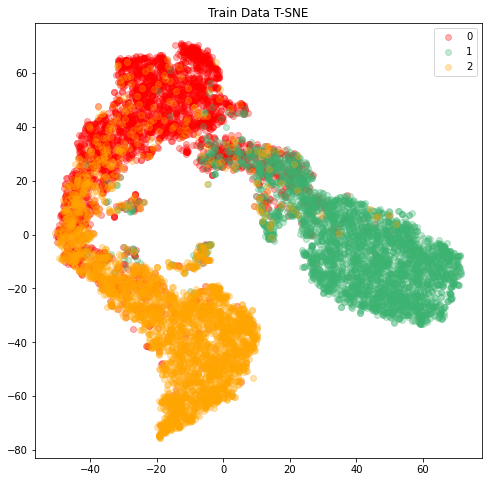

In [ ]:
# performing TSNE on test dataset
tx = test_tsne[:, 0]
ty = test_tsne[:, 1]
colors_per_class=[0,127,255]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Test Data T-SNE")
for label in [0,1,2]:
    indices = [i for i, l in enumerate(testlabelsGlobal) if l == label]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    colordict={0:'#ff0000',127:'#3cb371',255:'#ffa500'}
    color = colordict[colors_per_class[label]]
    ax.scatter(current_tx, current_ty, c=color, label=label,alpha=0.3)
ax.legend(loc='best')
plt.savefig('report_images/'+"test_tsne"+'_'+'.png')
plt.show()

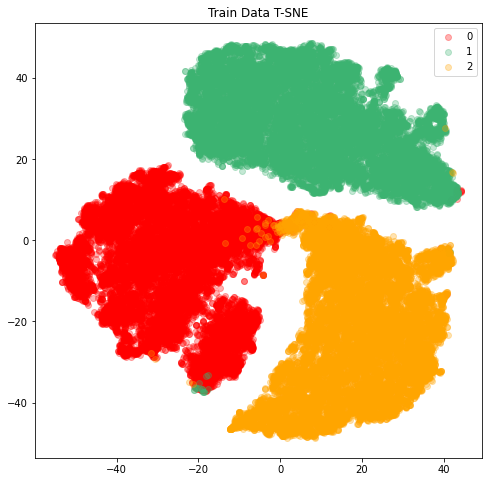

In [ ]:
# performing TSNE on test dataset
tx = train_tsne[:, 0]
ty = train_tsne[:, 1]
colors_per_class=[0,127,255]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Train Data T-SNE")
for label in [0,1,2]:
    indices = [i for i, l in enumerate(trainlabelsGlobal) if l == label]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    colordict={0:'#ff0000',127:'#3cb371',255:'#ffa500'}
    color = colordict[colors_per_class[label]]
    ax.scatter(current_tx, current_ty, c=color, label=label,alpha=0.3)
ax.legend(loc='best')
plt.savefig('report_images/'+"train_tsne"+'_'+'.png')
plt.show()